In [1]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import explained_variance_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# make sure TF does not allocate all memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [4]:
data = np.load('simple_600K_disc0.99_cleaned.npz')
x_train = data['observations']
p_train = data['actions']
v_train = data['rewards']
x_train.shape, p_train.shape, v_train.shape

((594333, 11, 11, 18), (594333,), (594333,))

In [5]:
data = np.load('valid_100K_disc0.99_cleaned.npz')
x_test = data['observations']
p_test = data['actions']
v_test = data['rewards']
x_test.shape, p_test.shape, v_test.shape

((95623, 11, 11, 18), (95623,), (95623,))

In [6]:
c = x = Input(shape=(11,11,18))
c = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(c)
c = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(c)
c = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(c)
h = Flatten()(c)
#h = Dense(128, activation='relu')(h)
p = Dense(6, activation="softmax", name='p')(h)
#h = Dense(128, activation='relu')(h)
v = Dense(1, activation="tanh", name='v')(h)
model = Model(x, [p, v])
model.summary()
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[0, 1], metrics={'p': 'accuracy'})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 11, 18)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 32)   5216        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 11, 11, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 11, 11, 32)   9248        conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [7]:
callbacks = [
    ModelCheckpoint('conv32_simple_value_best.h5', monitor='val_v_loss', verbose=1, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_v_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
]

In [8]:
history = model.fit(x_train, [p_train, v_train], batch_size=512, epochs=100, validation_data=(x_test, [p_test, v_test]), callbacks=callbacks)

Train on 594333 samples, validate on 95623 samples
Epoch 1/100
594333/594333 [==============================] - 48s 80us/step - loss: 0.1285 - p_loss: 1.7886 - v_loss: 0.1285 - p_acc: 0.2168 - val_loss: 0.1784 - val_p_loss: 1.7959 - val_v_loss: 0.1784 - val_p_acc: 0.2027

Epoch 00001: val_v_loss improved from inf to 0.17835, saving model to conv32_simple_value_best.h5
Epoch 2/100
594333/594333 [==============================] - 64s 108us/step - loss: 0.0844 - p_loss: 1.7971 - v_loss: 0.0844 - p_acc: 0.1998 - val_loss: 0.2188 - val_p_loss: 1.7998 - val_v_loss: 0.2188 - val_p_acc: 0.1835

Epoch 00002: val_v_loss did not improve from 0.17835
Epoch 3/100
594333/594333 [==============================] - 38s 64us/step - loss: 0.0684 - p_loss: 1.7966 - v_loss: 0.0684 - p_acc: 0.1885 - val_loss: 0.2291 - val_p_loss: 1.7958 - val_v_loss: 0.2291 - val_p_acc: 0.1824

Epoch 00003: val_v_loss did not improve from 0.17835
Epoch 4/100
594333/594333 [==============================] - 36s 61us/step - l

Text(0.5,1,'Value MSE')

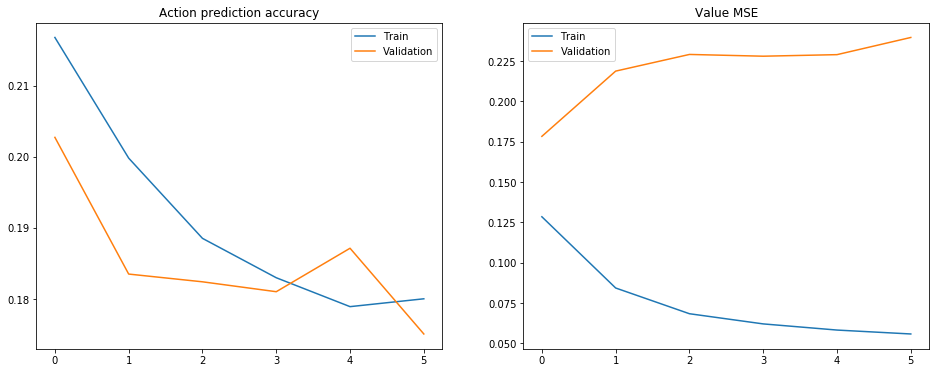

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['p_acc'])
plt.plot(history.history['val_p_acc'])
plt.legend(['Train', 'Validation'])
plt.title("Action prediction accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['v_loss'])
plt.plot(history.history['val_v_loss'])
plt.legend(['Train', 'Validation'])
plt.title("Value MSE")

In [10]:
model.save('conv32_simple_value_final.h5')
p_train_pred, v_train_pred = model.predict(x_train, batch_size=2048)
p_test_pred, v_test_pred = model.predict(x_test, batch_size=2048)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.17723565745129413
Accuracy test: 0.17509385817219705
Explained variance train: 0.6443678286212291
Explained variance test: -0.5905888801550181


In [11]:
model = load_model('conv32_simple_value_best.h5')
p_train_pred, v_train_pred = model.predict(x_train, batch_size=2048)
p_test_pred, v_test_pred = model.predict(x_test, batch_size=2048)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.20300403982279294
Accuracy test: 0.20272319421059787
Explained variance train: 0.32294052612962953
Explained variance test: -0.18984509809398675
